In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
df_shopping_malls = pd.read_csv("../auxiliary-data/sg-shopping-malls.csv")
df_shopping_malls = df_shopping_malls.drop('name', axis=1)
df_train = pd.read_csv("../data/train.csv")
df_shopping_malls.head()

,latitude,longitude
0,1.274588,103.843471
1,1.301385,103.837684
2,1.310867,103.863930
3,1.325596,103.842572
4,1.298141,103.855635


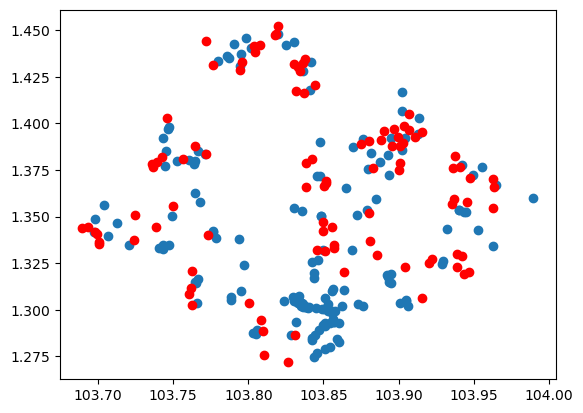

In [4]:
plt.scatter(df_shopping_malls['longitude'], df_shopping_malls['latitude'])
plt.scatter(df_train[:100]['longitude'], df_train[:100]['latitude'], color='r')
plt.show()

In [5]:
kmeans = KMeans(n_clusters=14, random_state=42)
kmeans.fit(df_shopping_malls)


KMeans(n_clusters=14, random_state=42)

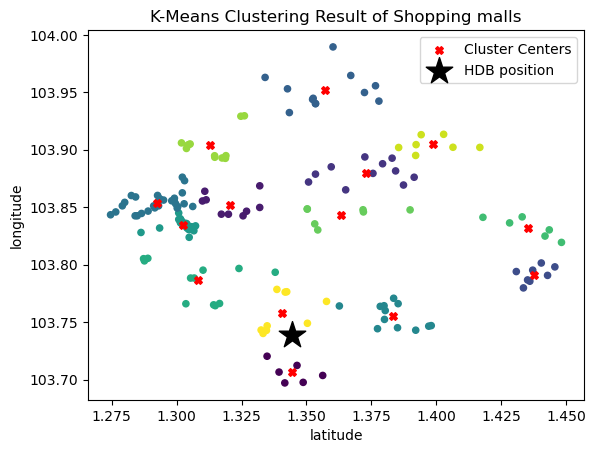

In [35]:
# Get the cluster centers and labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_
# Visualize the clustering result
plt.scatter(df_shopping_malls['latitude'], df_shopping_malls['longitude'], c=labels, s=20)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', label='Cluster Centers', s=30)
plt.scatter(df_train[:1]['latitude'], df_train[:1]['longitude'], c='black', marker='*', label='HDB position', s=400)
# plt.scatter(df_train[:2]['latitude'], df_train[:2]['longitude'], color='b')
plt.title('K-Means Clustering Result of Shopping malls')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend()
plt.show()

# Naive way of processing shopping mall counting

In [36]:
from geopy.distance import geodesic

# find the number of shopping malls in radius of the df
def num_shopping_malls_df(df, df_shopping_malls, radius=2):
    num_list = []
    for i in df.index:
        lat = df['latitude'][i]
        long = df['longitude'][i]
        num_shopping = num_shopping_malls_pt(lat, long, df_shopping_malls, radius)
        num_list.append(num_shopping)
    return num_list

    
    
# find the number of shopping malls in radius of a point
def num_shopping_malls_pt(lat, long, df_shopping_malls, radius=2):
    house_position = (lat, long)

    distances = []
    for i in df_shopping_malls.index:
        shopping_pos = (df_shopping_malls['latitude'][i], df_shopping_malls['longitude'][i])
        distance = geodesic(house_position, shopping_pos).km
        distances.append(distance)

    distances.sort()
    num_shopping = 0
    for d in distances:
        if d <= radius:
            num_shopping += 1
        else:
            break

    return num_shopping

In [20]:
%%time
num_list_ground_truth = num_shopping_malls_df(df_train[:5000], df_shopping_malls)

CPU times: user 1min 32s, sys: 326 ms, total: 1min 32s
Wall time: 1min 32s


# KMeans Clutering approach of finding number of shopping malls

In [37]:
import math
# find the number of shopping malls in radius of the df
def num_shopping_malls_df_Kmeans(df, df_shopping_malls, radius=2, k=3):
    
    # K-means
    kmeans = KMeans(n_clusters=14, random_state=42)
    kmeans.fit(df_shopping_malls)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    num_list = []
    for i in df.index:
        lat = df['latitude'][i]
        long = df['longitude'][i]
        #find the most three nearby centers
        nearby_centers = find_nearby_centers(lat, long, centers, k)
        df_partial_shopping = df_shopping_malls.iloc[np.where(np.isin(labels, nearby_centers))]
#         print(len(df_partial_shopping))
        num_shopping = num_shopping_malls_pt(lat, long, df_partial_shopping, radius)
        num_list.append(num_shopping)
    return num_list


def euclidean_distance(point1, point2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))


# find k nearest centers
def find_nearby_centers(lat, long, centers, k):
    distances = []
    house_position = (lat, long)
    for i, center in enumerate(centers):
        distance = euclidean_distance(house_position, (centers[i, 0], centers[i, 1]))
        distances.append((distance, i))
    distances.sort()
    return [i[1] for i in distances[:k]]

In [9]:
%%time
num_list_k_means = num_shopping_malls_df_Kmeans(df_train[:5000], df_shopping_malls)


CPU times: user 20.5 s, sys: 363 ms, total: 20.9 s
Wall time: 19.6 s


In [38]:
%%time
num_list_k_means_2 = num_shopping_malls_df_Kmeans(df_train[:5000], df_shopping_malls, k=2)



CPU times: user 28 s, sys: 386 ms, total: 28.3 s
Wall time: 26.9 s


In [28]:
def find_abs_diff(list1, list2):
    return np.sum(np.abs(np.array(list1) - np.array(list2)))

In [33]:
find_abs_diff(num_list_ground_truth, num_list_k_means[:5000])

0

In [30]:
find_abs_diff(num_list_ground_truth, num_list_k_means_2)

484

In [25]:
%%time
num_list_k_means = num_shopping_malls_df_Kmeans(df_train, df_shopping_malls)

CPU times: user 3min 54s, sys: 1.11 s, total: 3min 55s
Wall time: 3min 54s


# test on processing.py

In [31]:
from preprocessing import num_shopping_malls_df_Kmeans, num_shopping_malls_df

partial_df = df_train[:100].copy()
num_list_k_means = num_shopping_malls_df_Kmeans(partial_df, df_shopping_malls)

partial_df

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,num_shopping_malls
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,5
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,3
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,5
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,3
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-04,yishun,741,Yishun Avenue 5,4-room,new generation,93.0,yes,1985,1.430100,103.833118,0.0,yishun west,yishun,north region,3700,5
96,2021-03,sengkang,131,rivervale street,4 room,model a2,90.0,yes,1999,1.389344,103.903082,0.0,rivervale,sengkang,north-east region,2500,7
97,2021-06,woodlands,556,Woodlands Drive 53,5 room,improved,120.0,yes,1999,1.432928,103.796013,0.0,woodlands south,woodlands,north region,1750,8
98,2021-06,bedok,59,chai chee road,3 room,model a,76.0,yes,1984,1.324889,103.920247,0.0,kembangan,bedok,east region,2000,2


In [39]:
from preprocessing import process_date

process_date(df_train)

In [40]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,0.038835,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,0.504854,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,0.529126,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,0.033981,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,0.533981,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.038835,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979,1.366050,103.854168,0.0,chong boon,ang mo kio,north-east region,2200
59996,0.985437,bukit merah,95a,henderson road,4-room,model a,83.0,yes,2019,1.286493,103.821434,0.0,henderson hill,bukit merah,central region,4100
59997,0.509709,tampines,862a,tampines street 83,5-room,improved,122.0,yes,1988,1.355064,103.936507,0.0,tampines west,tampines,east region,2250
59998,0.970874,bedok,67,Bedok Sth Avenue 3,5-room,standard,123.0,yes,1977,1.318974,103.944076,0.0,bedok south,bedok,east region,4700
